In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 500

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train1000",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 0 0 2 3 6 6 4 6 4 0 3 4 0 1 5 7 5 2 8 3 6 8 3 2 4 0 7 8 6 1 5]


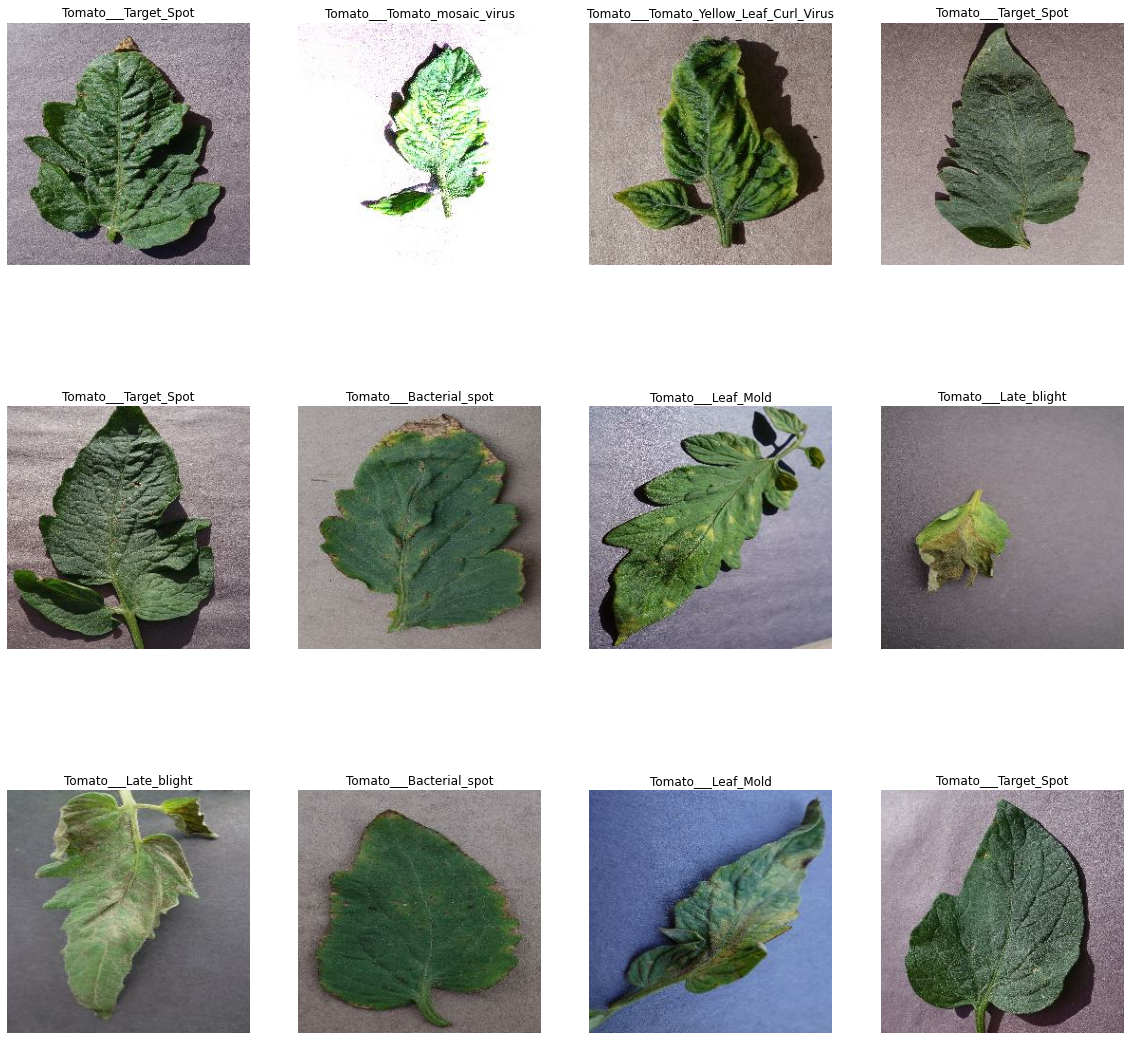

In [7]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% training 
20% ===> 10% validation, 10% test

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/500
250/250 [==============================] - 1123s 3s/step - loss: 1.9746 - accuracy: 0.2466 - val_loss: 1.7031 - val_accuracy: 0.3579
Epoch 2/500
250/250 [==============================] - 458s 2s/step - loss: 1.4499 - accuracy: 0.4748 - val_loss: 1.4107 - val_accuracy: 0.4990
Epoch 3/500
250/250 [==============================] - 514s 2s/step - loss: 1.1216 - accuracy: 0.6010 - val_loss: 1.5722 - val_accuracy: 0.4778
Epoch 4/500
250/250 [==============================] - 531s 2s/step - loss: 0.9269 - accuracy: 0.6765 - val_loss: 1.4167 - val_accuracy: 0.5252
Epoch 5/500
250/250 [==============================] - 668s 3s/step - loss: 0.7723 - accuracy: 0.7303 - val_loss: 1.1165 - val_accuracy: 0.6411
Epoch 6/500
250/250 [==============================] - 497s 2s/step - loss: 0.6426 - accuracy: 0.7719 - val_loss: 1.1491 - val_accuracy: 0.6280
Epoch 7/500
250/250 [==============================] - 586s 2s/step - loss: 0.5901 - accuracy: 0.7881 - val_loss: 0.9303 - val_accuracy

250/250 [==============================] - 615s 2s/step - loss: 0.0510 - accuracy: 0.9833 - val_loss: 0.0666 - val_accuracy: 0.9768
Epoch 114/500
250/250 [==============================] - 927s 4s/step - loss: 0.0439 - accuracy: 0.9856 - val_loss: 0.0809 - val_accuracy: 0.9718
Epoch 115/500
250/250 [==============================] - 710s 3s/step - loss: 0.0501 - accuracy: 0.9813 - val_loss: 0.0361 - val_accuracy: 0.9879
Epoch 116/500
250/250 [==============================] - 590s 2s/step - loss: 0.0565 - accuracy: 0.9811 - val_loss: 0.1702 - val_accuracy: 0.9587
Epoch 117/500
250/250 [==============================] - 802s 3s/step - loss: 0.0709 - accuracy: 0.9762 - val_loss: 0.2294 - val_accuracy: 0.9254
Epoch 118/500
250/250 [==============================] - 782s 3s/step - loss: 0.0596 - accuracy: 0.9801 - val_loss: 0.0708 - val_accuracy: 0.9758
Epoch 119/500
250/250 [==============================] - 925s 4s/step - loss: 0.0971 - accuracy: 0.9699 - val_loss: 0.1865 - val_accuracy:

250/250 [==============================] - 540s 2s/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0883 - val_accuracy: 0.9798
Epoch 226/500
250/250 [==============================] - 584s 2s/step - loss: 0.0287 - accuracy: 0.9894 - val_loss: 0.0706 - val_accuracy: 0.9808
Epoch 227/500
250/250 [==============================] - 538s 2s/step - loss: 0.0853 - accuracy: 0.9772 - val_loss: 0.0809 - val_accuracy: 0.9748
Epoch 228/500
250/250 [==============================] - 983s 4s/step - loss: 0.0385 - accuracy: 0.9886 - val_loss: 0.0623 - val_accuracy: 0.9829
Epoch 229/500
250/250 [==============================] - 291s 1s/step - loss: 0.0401 - accuracy: 0.9868 - val_loss: 0.0787 - val_accuracy: 0.9778
Epoch 230/500
250/250 [==============================] - 316s 1s/step - loss: 0.0480 - accuracy: 0.9848 - val_loss: 0.1865 - val_accuracy: 0.9506
Epoch 231/500
250/250 [==============================] - 836s 3s/step - loss: 0.0357 - accuracy: 0.9876 - val_loss: 0.0294 - val_accuracy:

250/250 [==============================] - 1091s 4s/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0514 - val_accuracy: 0.9869
Epoch 338/500
250/250 [==============================] - 733s 3s/step - loss: 0.0332 - accuracy: 0.9901 - val_loss: 0.0302 - val_accuracy: 0.9919
Epoch 339/500
250/250 [==============================] - 1012s 4s/step - loss: 0.0342 - accuracy: 0.9904 - val_loss: 0.1344 - val_accuracy: 0.9698
Epoch 340/500
250/250 [==============================] - 746s 3s/step - loss: 0.0379 - accuracy: 0.9899 - val_loss: 0.0411 - val_accuracy: 0.9849
Epoch 341/500
250/250 [==============================] - 690s 3s/step - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.1071 - val_accuracy: 0.9758
Epoch 342/500
250/250 [==============================] - 702s 3s/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0985 - val_accuracy: 0.9758
Epoch 343/500
250/250 [==============================] - 313s 1s/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.0431 - val_accurac

250/250 [==============================] - 776s 3s/step - loss: 0.0331 - accuracy: 0.9905 - val_loss: 0.1012 - val_accuracy: 0.9768
Epoch 450/500
250/250 [==============================] - 313s 1s/step - loss: 0.0438 - accuracy: 0.9879 - val_loss: 0.0487 - val_accuracy: 0.9829
Epoch 451/500
250/250 [==============================] - 516s 2s/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.0435 - val_accuracy: 0.9869
Epoch 452/500
250/250 [==============================] - 708s 3s/step - loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.0336 - val_accuracy: 0.9889
Epoch 453/500
250/250 [==============================] - 696s 3s/step - loss: 0.0413 - accuracy: 0.9875 - val_loss: 0.0786 - val_accuracy: 0.9728
Epoch 454/500
250/250 [==============================] - 871s 3s/step - loss: 0.0524 - accuracy: 0.9884 - val_loss: 0.2378 - val_accuracy: 0.9546
Epoch 455/500
250/250 [==============================] - 835s 3s/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.0419 - val_accuracy:

In [18]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 430s 564ms/step - loss: 0.0284 - accuracy: 0.9922


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

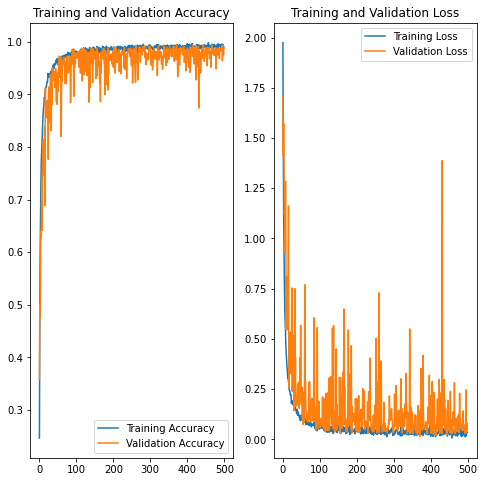

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus


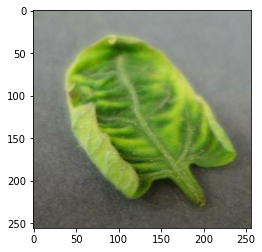

In [21]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

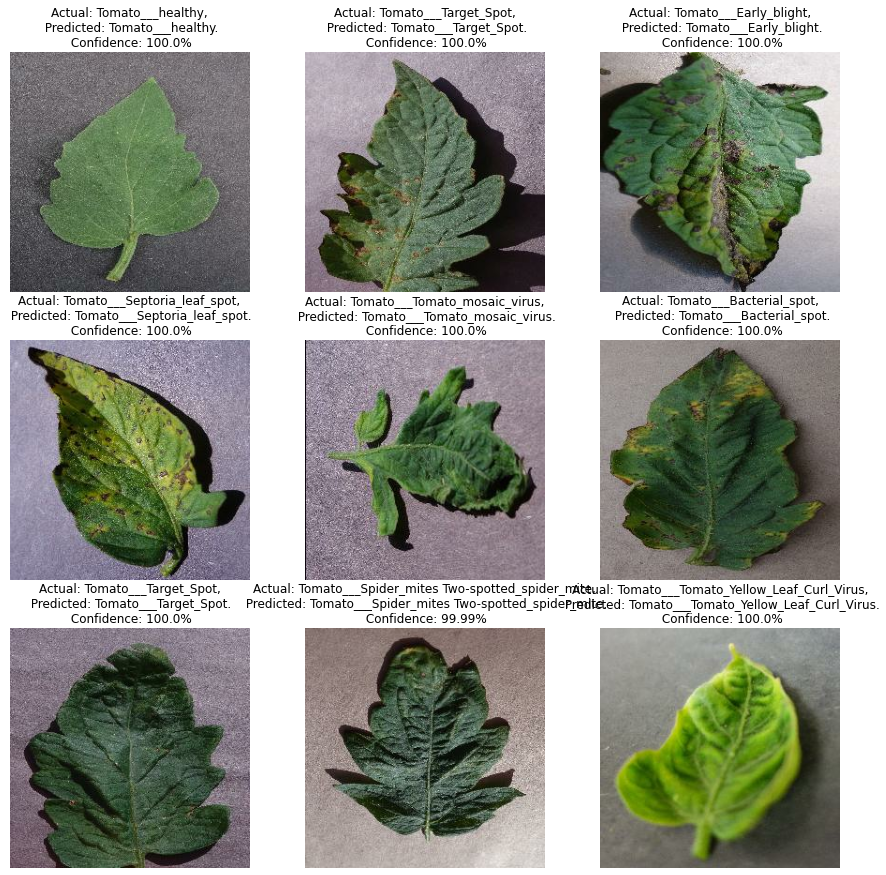

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


In [26]:
model.save("tpdp_train1000.h5")